_Behavior of the Maximum Likelihood in Quantum State Tomography_ - Supplemental Notebook II
================================

Travis Scholten and Robin Blume-Kohout, _Sandia National Labs_ and the _Center for Quantum Information and Control, University of New Mexico_

The purpose of this notebook is to explain the derivation of our solution for $q/\epsilon$, Equation ??, in our paper, available on the [arXiv](https://arxiv.org/abs/1609.04385).

This notebook requires having ``sympy``, ``matplotlib``, ``numpy``, ``pandas``, and ``seaborn``. If you don't want to install seaborn, then that's OK - the color schemes and formatting will just look a little bit different!

If you've arrived at this notebook by cloning the [GitHub repository for this paper](https://github.com/Travis-S/2016_MaxLik_Tomography), the data files referenced are located in the `Data` directory.

In the main text of the paper, we have to solve the following equation

$$\frac{rq}{\epsilon} = \frac{4N^{1/4}}{15\pi}\left(2\sqrt{N} - \frac{q}{\epsilon}\right)^{5/2}$$

for $q$, where $N  = d-r$. I'd like to see how close we can come to an exact solution.

We first start by defining $z \equiv q/\epsilon$, and then squaring both sides:

$$r^{2}z^{2} = \left(\frac{4}{15\pi}\right)^{2}\sqrt{N}\left(2\sqrt{N} - z\right)^{5}$$

Do an obvious thing: pull out the $2 \sqrt{N}$:

$$r^{2}z^{2} = 32\left(\frac{4}{15\pi}\right)^{2}N^{3}\left(1 - \frac{z}{2\sqrt{N}}\right)^{5}$$

Define $y  = z/2\sqrt{N}$:

$$r^{2}y^{2} = 32\left(\frac{4}{(15\pi)^{2}}\right)N^{2}\left(1 - y\right)^{5}$$

A few simplifications:

$$y^{2} = 32\left(\frac{2N}{15\pi r}\right)^{2}\left(1 - y\right)^{5}$$

Define $A =32\left(\frac{2N}{15\pi r}\right)^{2}$:

$$y^{2} = A\left(1 - y\right)^{5} \implies y^{2}-A*\left(1 - y\right)^{5} = 0$$

Check that things work thus far...

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

%load_ext autoreload
%autoreload 2

import sympy
from scipy import optimize

def a(d ,r):
    return 32 * (2 * (d - r) / (15 * np.pi * r))**2

def f(x, A):
    return x ** 2 - A*(1-x)**5
    
def exact_approx_x0(d, r):
    
    A = a(d, r)
    
    def g(x):
        return f(x, A)
    
    N = d - r
    
    #An exact numerical root
    return 2*np.sqrt(N) * optimize.newton(g, 0)

In [4]:
import pandas as pd
df = pd.read_csv('Data/avg_decrement.csv')
df = df[df['kind'] == 'q'].drop('numTrials', axis=1)

In [5]:
def theory_comp_plot(theory):
    df.loc[:, 'theory'] = df.apply(lambda r: theory(r['dim'], r['rankTrue']), axis=1)
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1)

    X = df['avg_dec'].values
    Y = df['theory'].values

    ax.plot(X, Y, ls='', marker='o')
    ax.plot(X, X, ls='-')

    colors = seaborn.color_palette('husl', n_colors = len(df['rankTrue'].unique()))
    ax = fig.add_subplot(1, 2, 2)
    counter = 0
    for r in df['rankTrue'].unique():
        temp = df[df['rankTrue'] == r].sort_values(by=['dim'])
        X = temp['dim'].values
        Y = temp['avg_dec'].values

        ax.plot(X, Y, ls='', marker='o', clip_on=False, color=colors[counter], label=r)

        Z = temp['theory'].values

        ax.plot(X, Z, ls='-', marker='', clip_on=False, color=colors[counter])

        counter += 1

    ax.legend(loc=0)

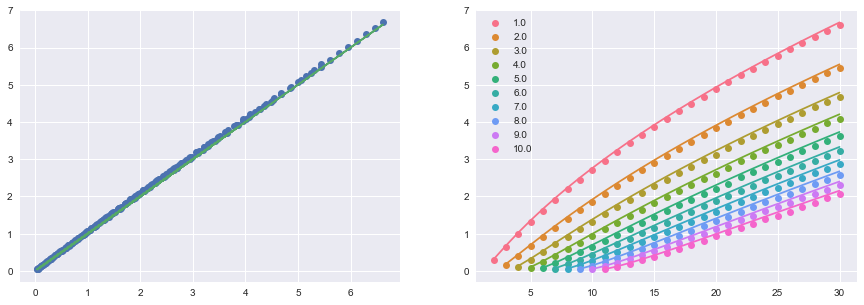

In [6]:
theory_comp_plot(exact_approx_x0)

Looks great! The problem is solving this quintic is hard. To make progress, observe that we may write the defining equation for $y$ as

$$y^{2/5} + A^{1/5}(y-1) = 0$$

Now, we use the fact that $y \approx 1$, and we compute the Taylor series of $y^{2/5}$ about $y_{0} = 1$:

In [7]:
sympy.init_printing(True)

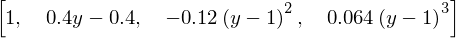

In [8]:
y = sympy.symbols('y')
[sympy.diff(y**(2/5), y, n).subs({y:1})/(sympy.factorial(n))*(y-1)**n for n in range(0, 4)]

The series is


$$y^{2/5} \approx 1 + .4(y-1)-.12(y-1)^{2} + \mathcal{O}((y-1)^{3})$$

Let's see how this Taylor series performs.

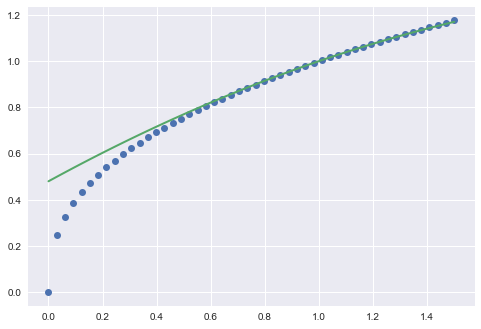

In [9]:
X = np.linspace(0, 1.5)
Z = 1 + .4*(X-1) - .12 * (X-1)**2
plt.plot(X, X**(2/5), ls='', marker='o')
plt.plot(X, Z, lw=2)

Replacing $y^{2/5}$ by its Taylor series, we now end up with a quadratic equation in $y$:

$$1 + (.4 + A^{1/5})(y-1)-.12(y-1)^{2} = 0$$

Let's check that the roots of this equation agree well with the original numerics.

In [10]:
def num_approx_x0(d, r):
    A = a(d, r)
    def f(x, a):
        return 1 + (.4 + a**.2)*(x-1)-.12*(x-1)**2
    def g(x):
        return f(x, A)
    
    N = d - r
    #Compute the numerical root
    return 2*np.sqrt(N) * optimize.newton(g, 0)

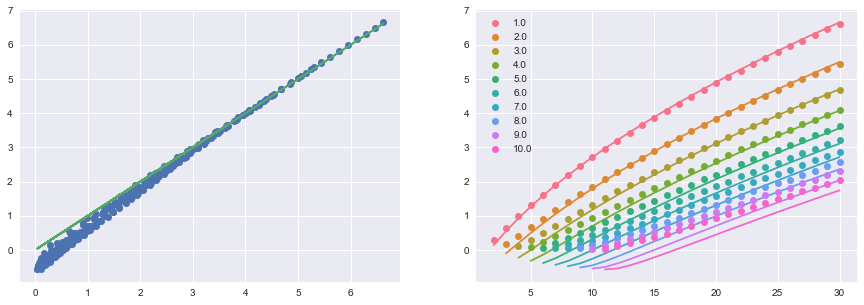

In [11]:
theory_comp_plot(num_approx_x0)

There's reasonable agreement. Now let's try to solve this equation algebraically.

In [12]:
A,y = sympy.symbols('A,y')
f = 1 + (.4 + A**.2)*(y-1)-.12*(y-1)**2

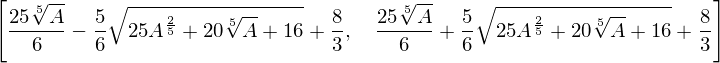

In [13]:
sols = sympy.solve(f, y, rational=True)
sols

Now, we can plot each of the roots and see which is right.

In [14]:
def approx_x0(d, r, root='pos'):
    
    A = a(d, r)  
    N = d - r
    
    t1 = 25*A**(1/5)/6 + 8/3
    
    t2 = 5/6*np.sqrt(25.0*A**(2/5) + 20*A**(1/5) + 16)
    
    if root == 'pos':
        v = t1+t2
    else:
        v = t1 - t2

    return 2*np.sqrt(N)*v

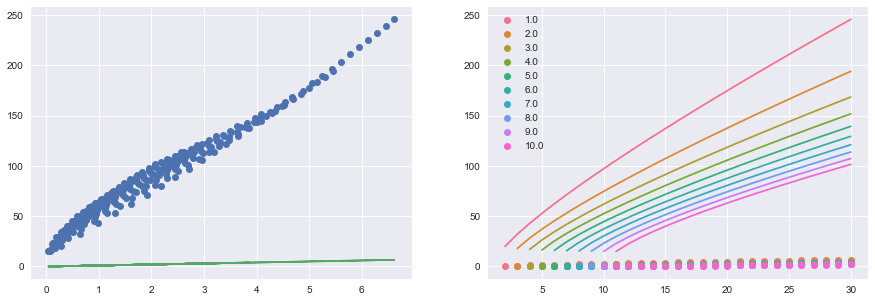

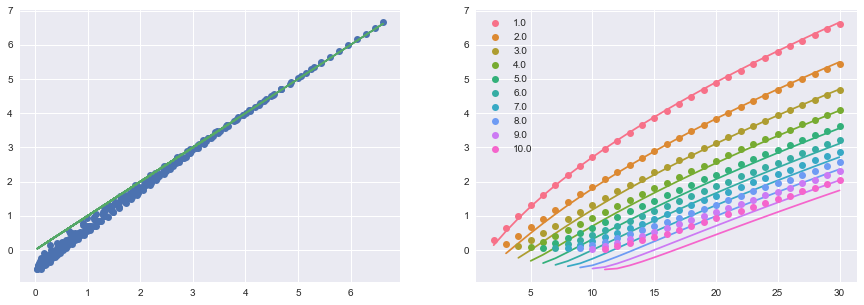

In [15]:
theory_comp_plot(lambda d, r: approx_x0(d,r)),
theory_comp_plot(lambda d, r: approx_x0(d,r, root='neg'))

Looks like we should use the negative root.

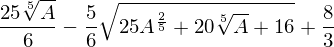

In [16]:
sols[0]

In turn, the decrement $z$ is given by

$$z = 2\sqrt{N}\left(\frac{25A^{1/5}}{6} - \frac{5}{6}\sqrt{25A^{2/5} + 20 A^{1/5} + 16} + \frac{8}{3}\right)$$

with

$$A =32\left(\frac{2N}{15\pi r}\right)^{2}$$

Let's try to take the $N \rightarrow \infty$ limit of this root.

In [17]:
N,r,t = sympy.symbols('N,r,t', real=True, positive=True)

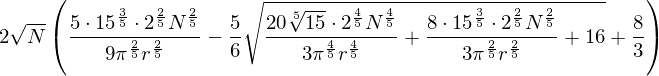

In [18]:
z = 2*sympy.sqrt(N)*sols[0].subs({A:32 * (2 * N / (15 * sympy.pi * r))**2})
z

Take $N \rightarrow \infty$ by defining $t = r/N$, and taking $t \rightarrow 0$.

It turns out it will be helpful to define a new quantity, $B = \frac{15 \pi r}{2}$, to do the simplification:

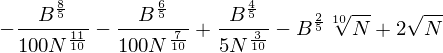

In [19]:
sympy.init_printing()
B = sympy.symbols('B')
sympy.expand(sympy.series(z.subs({N:r/t}), t, n=2).subs({t:r/N})).removeO().subs({r: 2*B/(15 * sympy.pi)})

Re-writing in terms of $r$, we have a nice expression for $z$:

$$z = 2\sqrt{N} - \left(\frac{15\pi r}{2}\right)^{2/5}N^{1/10} + \frac{1}{5}\left(\frac{15\pi r}{2}\right)^{4/5}N^{-3/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{6/5}N^{-7/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{8/5}N^{-11/10}$$

Let's see whether these additional terms help...

In [20]:
def approx_x0_2(d, r, order=7):
    N  = d - r
    
    A = (15 * np .pi * r / 2)
    
    z = 2* np.sqrt(N) - A**(2/5)*N**(1/10) + 1/5 * (A ** (4/5)) * N**(-3/10) - 1/100 * A**(6/5)*N**(-7/10) 
    if order == 7:
        z += 0
    elif order == 10:
        z += - 1/100 * A**(8/5)*N**(-11/10)

    return z

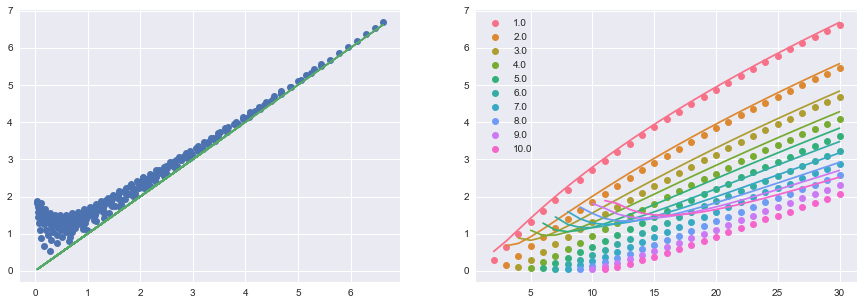

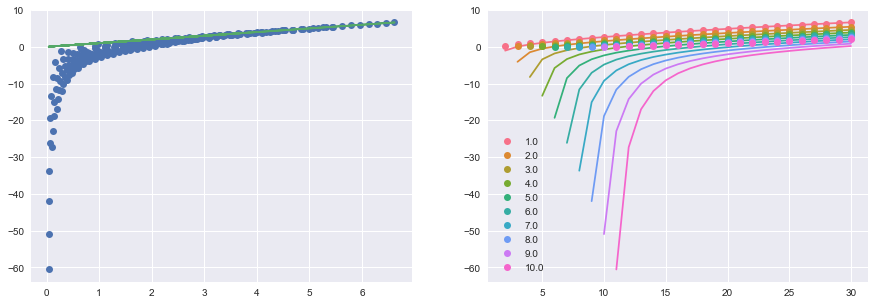

In [21]:
theory_comp_plot(approx_x0_2)
theory_comp_plot(lambda d, r: approx_x0_2(d, r, order=10))

Adding in the $N^{-7/10}$ does help, but adding in $N^{-11/10}$ does not.

$$\boxed{z \equiv \frac{q}{\epsilon} = 2\sqrt{N} - \left(\frac{15\pi r}{2}\right)^{2/5}N^{1/10} + \frac{1}{5}\left(\frac{15\pi r}{2}\right)^{4/5}N^{-3/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{6/5}N^{-7/10}}$$